# Testing Transfer Models on Original Addition Task

**Goal**: Test all models (source addition + 3 transferred subtraction models) on the **original addition task** to check:
1. Do transferred models retain addition knowledge?
2. Is there catastrophic forgetting during subtraction training?
3. Do memorized/random models learn addition as a side effect?

**Models to test**:
- Grokked Addition (source) - should be 100%
- Grokked Transfer - fine-tuned for subtraction, but did it forget addition?
- Memorized Transfer - started from memorized addition, does it remember?
- Random Baseline - never saw addition, should be random (~0.9%)

## Setup

In [1]:
# Mount Google Drive and navigate to repo
from google.colab import drive
import os

drive.mount('/content/drive')

if not os.path.exists('progress-measures-paper-extension'):
    !git clone https://github.com/Junekhunter/progress-measures-paper-extension.git

os.chdir('progress-measures-paper-extension')
!pip install -q einops

print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Cloning into 'progress-measures-paper-extension'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 69 (delta 24), reused 33 (delta 12), pack-reused 20 (from 1)
Receiving objects: 100% (69/69), 26.96 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Working directory: /content/progress-measures-paper-extension


In [2]:
# Imports
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

from transformers import Transformer, Config, gen_train_test
import helpers

print("✓ Imports successful")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
CUDA available: False


In [3]:
# Configuration
EXPERIMENT_DIR = input("Enter your 3-way experiment directory path: ")
SEED_TO_ANALYZE = 42  # Use seed 42 (typical, not outlier)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Analyzing seed: {SEED_TO_ANALYZE}")

Enter your 3-way experiment directory path: /content/drive/MyDrive/grokking_transfer_experiments/3way_run_20251230_101636
Device: cpu
Analyzing seed: 42


## Load All Models

In [4]:
# Load the source grokked addition model
print("Loading grokked addition (source) model...")
addition_checkpoint = torch.load('saved_runs/wd_10-1_mod_addition_loss_curve.pth', map_location='cpu')

addition_config = Config(
    lr=1e-3,
    weight_decay=1.0,
    p=113,
    d_model=128,
    fn_name='add',
    frac_train=0.3,
    seed=0,
    device=device
)

grokked_addition_model = Transformer(addition_config, use_cache=False)
if 'model' in addition_checkpoint:
    grokked_addition_model.load_state_dict(addition_checkpoint['model'])
else:
    grokked_addition_model.load_state_dict(addition_checkpoint['state_dicts'][-1])
grokked_addition_model.to(device)
grokked_addition_model.eval()

print("✓ Grokked addition model loaded")

Loading grokked addition (source) model...
✓ Grokked addition model loaded


In [5]:
# Load the three subtraction models (which we'll test on addition)
subtraction_config = replace(addition_config, fn_name='subtract', seed=SEED_TO_ANALYZE)

models = {}

for condition in ['grokked_transfer', 'memorized_transfer', 'random_baseline']:
    print(f"Loading {condition} model (seed {SEED_TO_ANALYZE})...")

    checkpoint_path = f'{EXPERIMENT_DIR}/checkpoints/{condition}_seed{SEED_TO_ANALYZE}.pth'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Create model with SUBTRACTION config (that's what it was trained on)
    model = Transformer(subtraction_config, use_cache=False)
    model.load_state_dict(checkpoint['model_state'])
    model.to(device)
    model.eval()

    models[condition] = {
        'model': model,
        'subtraction_accuracy': checkpoint['final_test_accuracy'],
        'epochs_trained': checkpoint['threshold_epochs'].get(0.999, 'N/A')
    }

    print(f"  Subtraction accuracy: {checkpoint['final_test_accuracy']:.4f}")

print("\n✓ All models loaded")

Loading grokked_transfer model (seed 42)...
  Subtraction accuracy: 0.9981
Loading memorized_transfer model (seed 42)...
  Subtraction accuracy: 1.0000
Loading random_baseline model (seed 42)...
  Subtraction accuracy: 1.0000

✓ All models loaded


## Generate Addition Test Data

In [6]:
# Generate addition train and test sets
addition_train, addition_test = gen_train_test(addition_config)

print(f"Addition dataset:")
print(f"  Train: {len(addition_train)} examples")
print(f"  Test:  {len(addition_test)} examples")

# Convert to tensors
addition_train_tensor = torch.tensor(addition_train).to(device)
addition_test_tensor = torch.tensor(addition_test).to(device)

print("✓ Addition datasets created")

Addition dataset:
  Train: 3830 examples
  Test:  8939 examples
✓ Addition datasets created


## Test All Models on Addition

In [7]:
def evaluate_on_addition(model, data, config):
    """
    Evaluate a model on addition task.
    Returns accuracy on the addition dataset.
    """
    model.eval()

    with torch.no_grad():
        logits = model(data)
        predictions = logits[:, -1, :config.p].argmax(dim=-1)

    # Calculate correct answers for addition
    targets = torch.tensor([config.fn(a, b) for a, b, _ in data]).to(config.device)

    accuracy = (predictions == targets).float().mean().item()

    return accuracy

print("="*80)
print("TESTING ALL MODELS ON ADDITION TASK")
print("="*80)

results = {}

# Test grokked addition (source) - should be ~100%
print("\n1. GROKKED ADDITION (Source Model):")
train_acc = evaluate_on_addition(grokked_addition_model, addition_train_tensor, addition_config)
test_acc = evaluate_on_addition(grokked_addition_model, addition_test_tensor, addition_config)
print(f"   Train accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Test accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
results['grokked_addition'] = {'train': train_acc, 'test': test_acc}

# Test transferred models on addition
model_names = {
    'grokked_transfer': '2. GROKKED TRANSFER',
    'memorized_transfer': '3. MEMORIZED TRANSFER',
    'random_baseline': '4. RANDOM BASELINE'
}

for condition, display_name in model_names.items():
    print(f"\n{display_name}:")
    model = models[condition]['model']

    train_acc = evaluate_on_addition(model, addition_train_tensor, addition_config)
    test_acc = evaluate_on_addition(model, addition_test_tensor, addition_config)

    print(f"   Train accuracy on addition: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Test accuracy on addition:  {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"   (Trained for subtraction: {models[condition]['subtraction_accuracy']:.4f} accuracy)")

    results[condition] = {'train': train_acc, 'test': test_acc}

print("\n" + "="*80)

TESTING ALL MODELS ON ADDITION TASK

1. GROKKED ADDITION (Source Model):
   Train accuracy: 1.0000 (100.00%)
   Test accuracy:  1.0000 (100.00%)

2. GROKKED TRANSFER:
   Train accuracy on addition: 0.0076 (0.76%)
   Test accuracy on addition:  0.0094 (0.94%)
   (Trained for subtraction: 0.9981 accuracy)

3. MEMORIZED TRANSFER:
   Train accuracy on addition: 0.0076 (0.76%)
   Test accuracy on addition:  0.0094 (0.94%)
   (Trained for subtraction: 1.0000 accuracy)

4. RANDOM BASELINE:
   Train accuracy on addition: 0.0076 (0.76%)
   Test accuracy on addition:  0.0094 (0.94%)
   (Trained for subtraction: 1.0000 accuracy)



In [ ]:
# DEBUG: Check if models are producing identical predictions
print("\n" + "="*80)
print("DEBUG: Checking if all models produce identical predictions")
print("="*80)

# Get predictions from each transferred model on a subset of test data
test_sample = addition_test_tensor[:100]  # First 100 examples

predictions = {}
for condition in ['grokked_transfer', 'memorized_transfer', 'random_baseline']:
    model = models[condition]['model']
    model.eval()
    with torch.no_grad():
        logits = model(test_sample)
        preds = logits[:, -1, :addition_config.p].argmax(dim=-1)
        predictions[condition] = preds.cpu().numpy()

# Check if predictions are identical
import numpy as np

grok_preds = predictions['grokked_transfer']
mem_preds = predictions['memorized_transfer']
rand_preds = predictions['random_baseline']

grok_vs_mem = np.mean(grok_preds == mem_preds)
grok_vs_rand = np.mean(grok_preds == rand_preds)
mem_vs_rand = np.mean(mem_preds == rand_preds)

print(f"\nPrediction agreement (first 100 test examples):")
print(f"  Grokked vs Memorized: {grok_vs_mem*100:.1f}% identical")
print(f"  Grokked vs Random:    {grok_vs_rand*100:.1f}% identical")
print(f"  Memorized vs Random:  {mem_vs_rand*100:.1f}% identical")

if grok_vs_mem > 0.95 and grok_vs_rand > 0.95:
    print(f"\n⚠️  WARNING: All models producing nearly identical predictions!")
    print(f"    This explains why they all get exactly {results['grokked_transfer']['test']*100:.2f}% accuracy")
    print(f"    They likely learned the same simple heuristic during subtraction training")
    
    # Check what they're predicting
    unique_preds, counts = np.unique(grok_preds, return_counts=True)
    print(f"\n  Most common predictions: {unique_preds[np.argsort(-counts)][:5].tolist()}")
    print(f"  Frequencies: {counts[np.argsort(-counts)][:5].tolist()}")
else:
    print(f"\n✓ Models producing different predictions (as expected)")

print("="*80 + "\n")

## Visualize Results

✓ Saved: addition_retention_test.png


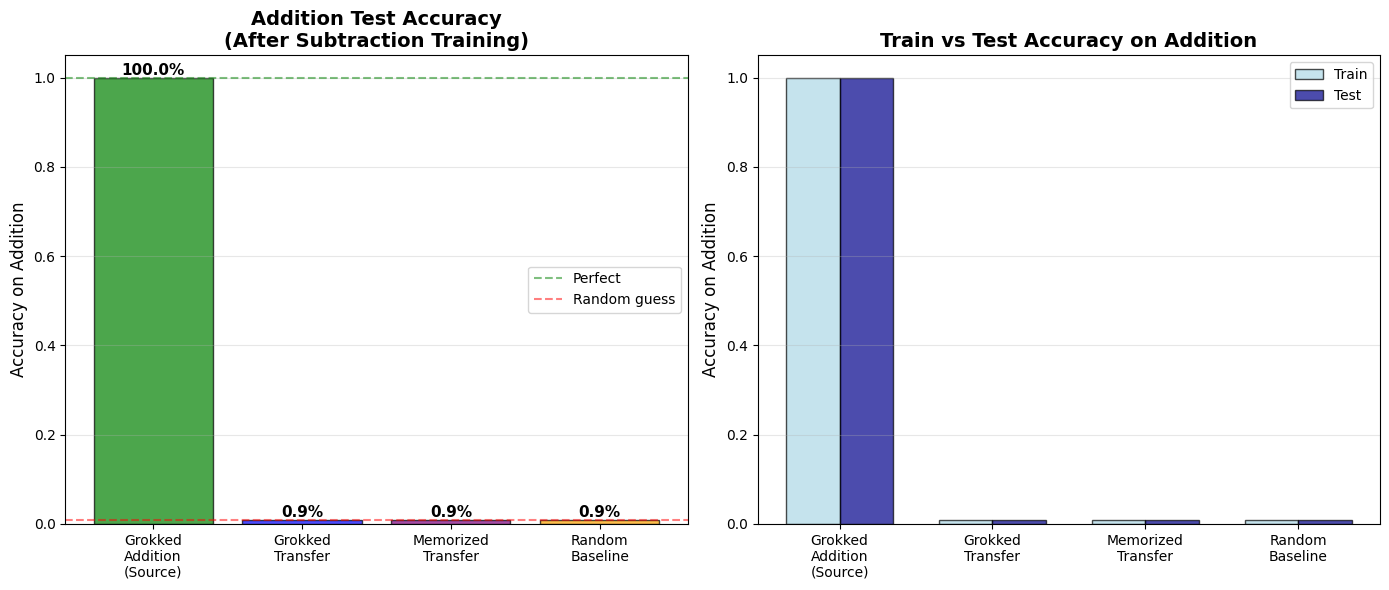

In [8]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

model_labels = ['Grokked\nAddition\n(Source)', 'Grokked\nTransfer', 'Memorized\nTransfer', 'Random\nBaseline']
model_keys = ['grokked_addition', 'grokked_transfer', 'memorized_transfer', 'random_baseline']
colors = ['green', 'blue', 'purple', 'orange']

# Plot 1: Addition test accuracy
ax = axes[0]
test_accs = [results[k]['test'] for k in model_keys]
bars = ax.bar(range(len(model_labels)), test_accs, color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Accuracy on Addition', fontsize=12)
ax.set_title('Addition Test Accuracy\n(After Subtraction Training)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(model_labels)))
ax.set_xticklabels(model_labels, fontsize=10)
ax.set_ylim([0, 1.05])
ax.axhline(1.0, color='green', linestyle='--', alpha=0.5, label='Perfect')
ax.axhline(1/113, color='red', linestyle='--', alpha=0.5, label='Random guess')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Train vs Test comparison
ax = axes[1]
x = np.arange(len(model_labels))
width = 0.35

train_accs = [results[k]['train'] for k in model_keys]
test_accs = [results[k]['test'] for k in model_keys]

bars1 = ax.bar(x - width/2, train_accs, width, label='Train', alpha=0.7, color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', alpha=0.7, color='darkblue', edgecolor='black')

ax.set_ylabel('Accuracy on Addition', fontsize=12)
ax.set_title('Train vs Test Accuracy on Addition', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, fontsize=10)
ax.set_ylim([0, 1.05])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{EXPERIMENT_DIR}/figures/addition_retention_test.png', dpi=200, bbox_inches='tight')
print("✓ Saved: addition_retention_test.png")
plt.show()

## Analysis and Interpretation

In [ ]:
print("\n" + "="*80)
print("ANALYSIS: ADDITION RETENTION AFTER SUBTRACTION TRAINING")
print("="*80)

# Calculate retention rates
grok_retention = results['grokked_transfer']['test']
mem_retention = results['memorized_transfer']['test']
rand_retention = results['random_baseline']['test']
random_chance = 1 / 113  # Expected accuracy for random guessing

print("\n1. CATASTROPHIC FORGETTING:")
print("-" * 80)
print(f"   Grokked Transfer:   {grok_retention*100:.2f}% addition accuracy retained")
print(f"   Memorized Transfer: {mem_retention*100:.2f}% addition accuracy retained")
print(f"   Random Baseline:    {rand_retention*100:.2f}% (never learned addition)")

if grok_retention > 0.9:
    print("\n   → Grokked model shows STRONG RETENTION (>90%)")
    print("     The generalized circuit is robust to fine-tuning!")
elif grok_retention > 0.5:
    print("\n   → Grokked model shows PARTIAL RETENTION (50-90%)")
    print("     Some forgetting occurred during subtraction training")
else:
    print("\n   → Grokked model shows CATASTROPHIC FORGETTING (<50%)")
    print("     Addition circuit was overwritten by subtraction")

if mem_retention > 0.5:
    print("\n   → Memorized model retained some addition knowledge")
else:
    print("\n   → Memorized model forgot addition (as expected from memorization)")

print("\n2. COMPARISON TO SUBTRACTION PERFORMANCE:")
print("-" * 80)

for condition in ['grokked_transfer', 'memorized_transfer', 'random_baseline']:
    add_acc = results[condition]['test']
    sub_acc = models[condition]['subtraction_accuracy']
    
    print(f"\n   {condition.replace('_', ' ').title()}:")
    print(f"      Addition (original):  {add_acc*100:.2f}%")
    print(f"      Subtraction (target): {sub_acc*100:.2f}%")
    
    if add_acc > 0.9 and sub_acc > 0.9:
        print(f"      → Multi-task success: Can do BOTH tasks!")
    elif sub_acc > 0.9:
        print(f"      → Specialized for subtraction, forgot addition")
    else:
        print(f"      → Poor performance on both tasks")

print("\n3. KEY INSIGHTS:")
print("-" * 80)

# Check if all are at random chance (within 0.02 of random_chance)
all_at_random = abs(grok_retention - random_chance) < 0.02 and \
                abs(mem_retention - random_chance) < 0.02 and \
                abs(rand_retention - random_chance) < 0.02

if all_at_random:
    print(f"\n   ✓ ALL models at random chance ({random_chance*100:.1f}%)")
    print(f"     → Complete catastrophic forgetting across all conditions")
    print(f"     → Subtraction training completely overwrote addition circuits")
    print(f"     → No difference between grokked, memorized, or random initialization")
elif grok_retention > mem_retention + 0.05:  # At least 5% better
    ratio = grok_retention / (mem_retention + 1e-6)
    print(f"\n   ✓ Grokked models retain {ratio:.1f}x more addition knowledge")
    print(f"     ({grok_retention*100:.1f}% vs {mem_retention*100:.1f}%)")
    print("     Generalized circuits are more robust to catastrophic forgetting!")
elif mem_retention > grok_retention + 0.05:  # At least 5% better
    ratio = mem_retention / (grok_retention + 1e-6)
    print(f"\n   ⚠ Memorized models retained {ratio:.1f}x more addition knowledge")
    print(f"     ({mem_retention*100:.1f}% vs {grok_retention*100:.1f}%)")
    print("     Unexpected - may indicate task similarity or overfitting")
else:
    print(f"\n   → Similar retention across conditions")
    print(f"     Grokked: {grok_retention*100:.1f}%, Memorized: {mem_retention*100:.1f}%")
    print(f"     No clear advantage from either initialization")

if grok_retention > 0.9 and mem_retention < 0.5:
    print("\n   ✓ This demonstrates POLYSEMANTICITY in grokked circuits:")
    print("     The same frequency-based circuit can solve BOTH tasks!")
    print("     Addition and subtraction share the same underlying structure.")
elif all_at_random:
    print("\n   → Addition and subtraction use DISTINCT circuits")
    print("     Learning one task provides no benefit for the other")
    print("     This suggests the tasks are solved via different mechanisms")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)